In [1]:

import json
import pandas as pd
import numpy as np
from toolz import memoize
import datetime
import math

from tqdm import tqdm
from src.utils.mouselab_jas import MouselabJas
from src.utils.distributions import Normal, expectation
from src.utils.env_creation import create_tree, create_init
from src.utils.env_export import create_json
from src.utils.data_classes import MouselabConfig, Action
from simulation import run_simulation
from src.policy.jas_voc_policy import JAS_voc_policy
from src.policy.jas_policy import RandomPolicy, ExhaustivePolicy, RandomNPolicy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from src.utils.utils import sigma_to_tau
import numpy as np
from src.utils.env_export import format_payoff
from src.utils.khalili_env import get_env


sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.5)
sns.set_theme()

%load_ext autoreload
%autoreload 2

In [15]:
data = json.load(open("./data/dataclips_4.json"))

In [16]:
language_index = data["fields"].index("language")
response_data_index = data["fields"].index("datastring")
begin_index = data["fields"].index("beginhit")
end_index = data["fields"].index("endhit")

f = '%Y-%m-%d %H:%M:%S.%f'

In [17]:
# Fixed from paper
env, config = get_env(5, term_belief=False)
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.5798921379230035)

In [18]:
def convert_action(project: int, criteria: int, expert: int, config: MouselabConfig) -> Action:
    query = (1 + criteria) + project*config.num_criterias
    action = Action(expert=expert, query=query)
    return action

In [19]:
df_index = ["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection",
        "Seed", "ClickAgreement"]    
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0
demographics = []

participant_actions = []

# Parse raw mturk data into dataframe
for p_index, p_data in tqdm(enumerate(data["values"])):
    # Filter out empty responses
    language = p_data[language_index]
    response_data = p_data[response_data_index]
    if p_data[begin_index] and p_data[end_index]:
        begin = datetime.datetime.strptime(p_data[begin_index], f)
        end = datetime.datetime.strptime(p_data[end_index], f)
        duration = (end - begin).total_seconds()
    else:
        duration = None
    if (response_data != None):
        p_res_obj = json.loads(response_data)
        if (not p_res_obj["workerId"].startswith("debug")):
            condition = p_res_obj["condition"]
            worker = p_index # p_res_obj["workerId"]#
            if worker in known_workers:
                print("Duplicate worker", worker)
            else: 
                known_workers.append(worker)
            p_res = p_res_obj["data"]
            participant_responses = []
            if "quiz_failures" in p_res_obj["questiondata"].keys():
                quiz_failures = p_res_obj["questiondata"]["quiz_failures"]
            else:
                quiz_failures = 0
            if "final_bonus" in p_res_obj["questiondata"].keys():
                bonus =  p_res_obj["questiondata"]["final_bonus"]
            else:
                bonus = 0
            participant_survey = {"Participant": worker, "Condition": condition, "Language": language, "QuizAttempts": 0, "QuizFailures": quiz_failures, "Bonus": bonus, "Duration": duration}
            completed_test_trials = sum([1 if ('trial_id' in  p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test")) else 0 for i in range(len(p_res))])
            if (quiz_failures < 3) and (completed_test_trials == 10):
                for i in range(len(p_res)):
                    # Get test trials
                    if 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test"):
                        trial_id = p_res[i]['trialdata']['trial_id']
                        seed = int(p_res[i]['trialdata']['seed'])
                        ground_truth = p_res[i]['trialdata']['ground_truth']
                        # project, criteria, expert
                        clicks = p_res[i]['trialdata']["clicks"]
                        num_clicks = len(clicks)
                        selected_project = p_res[i]['trialdata']["selected_project"]
                        term_reward = p_res[i]['trialdata']["reward"]
                        expected_reward = p_res[i]['trialdata']["expected_reward"]
                        # Calculate real env rewards
                        env.reset(seed=seed)
                        actions = [convert_action(*click, config) for click in clicks]
                        participant_actions.extend(actions)
                        cost = 0
                        # Click agreement
                        click_agreement = []
                        for action in actions:
                            optimal_actions = voc_policy.get_best_actions(env, eps=0.001)
                            if action in optimal_actions:
                                click_agreement.append(1)
                            else:
                                click_agreement.append(0)
                            _, reward, _, _ = env.step(action)
                            cost += reward
                        optimal_actions = voc_policy.get_best_actions(env)
                        if env.term_action in optimal_actions:
                            click_agreement.append(1)
                        else:
                            click_agreement.append(0)
                        path = np.array(range(1, config.num_criterias+1))+(selected_project*config.num_criterias)
                        env_expected_reward = cost + env.expected_path_value(path, env.state)
                        env_term_reward = cost + env.path_value(path)
                        assert np.all(np.isclose(ground_truth, env.ground_truth.tolist()))
                        assert np.all(np.isclose(np.array(format_payoff(config.num_projects, config.num_criterias, env.expert_truths.tolist())), p_res[i]['trialdata']['payoff_matrix']))
                        assert np.isclose(term_reward, env_term_reward)
                        assert np.isclose(expected_reward, env_expected_reward)
                        
                        #["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection", "Seed", "ClickAgreement"]  
                        df_data.append([worker, condition, trial_id, term_reward, expected_reward, num_clicks, clicks, selected_project, seed, np.mean(click_agreement)])
                    elif 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("train"):
                        pass
                    elif p_res[i]['trialdata']["trial_type"] == "survey-text":
                        #print(p_res[i]['trialdata'].keys())
                        print(p_res[i]['trialdata']["response"])
                        for key, val in p_res[i]['trialdata'].items():
                            pass
                            #print(key, val)
                    

df = pd.DataFrame(df_data, columns=df_index)
print("Responses:", len(df["Participant"].unique()))

3it [00:09,  3.22s/it]

{'Age': '28', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'no'}


5it [00:18,  3.91s/it]

{'Age': '21', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'no'}


6it [00:28,  5.34s/it]

{'Age': '39', 'Gender': 'MALE', 'Issues': 'None', 'Feedback': 'None'}


7it [00:37,  6.23s/it]

{'Age': '23', 'Gender': 'Male', 'Issues': '', 'Feedback': ''}


8it [00:47,  7.30s/it]

{'Age': '29', 'Gender': 'male', 'Issues': 'no', 'Feedback': ''}


9it [00:55,  7.72s/it]

{'Age': '25', 'Gender': 'Female', 'Issues': 'no issues', 'Feedback': ''}


10it [01:05,  8.31s/it]

{'Age': '24', 'Gender': 'Male', 'Issues': 'N/A', 'Feedback': 'N/A'}


11it [01:07,  6.15s/it]

{'Age': '28', 'Gender': 'Female', 'Issues': 'No', 'Feedback': ''}
Responses: 8


In [20]:
df.groupby("Participant").mean()

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_7220\2616027.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Participant").mean()


,Condition,Score,ExpectedScore,NumClicks,Selection,Seed,ClickAgreement
Participant,,,,,,,
2,1.0,3.733008,3.632706,4.8,2.0,16.5,0.666667
4,2.0,3.477030,3.460968,5.0,1.2,16.5,0.233333
5,0.0,3.589183,3.481831,4.9,2.7,16.5,0.166667
6,1.0,4.021638,3.668195,4.0,2.5,16.5,0.808333
7,2.0,3.669696,3.500740,4.9,2.4,16.5,0.423333
8,0.0,3.539717,3.540522,4.1,2.6,16.5,0.200000
9,1.0,4.001136,3.664950,4.9,1.9,16.5,0.846667
10,2.0,3.536523,3.401164,0.0,1.6,16.5,0.000000


C:\Users\lheindrich\AppData\Local\Temp\ipykernel_7220\3118699708.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.histplot(df.groupby("Participant").mean(), x="ClickAgreement", hue="Condition", shrink=0.9, multiple="dodge")


<AxesSubplot: xlabel='ClickAgreement', ylabel='Count'>

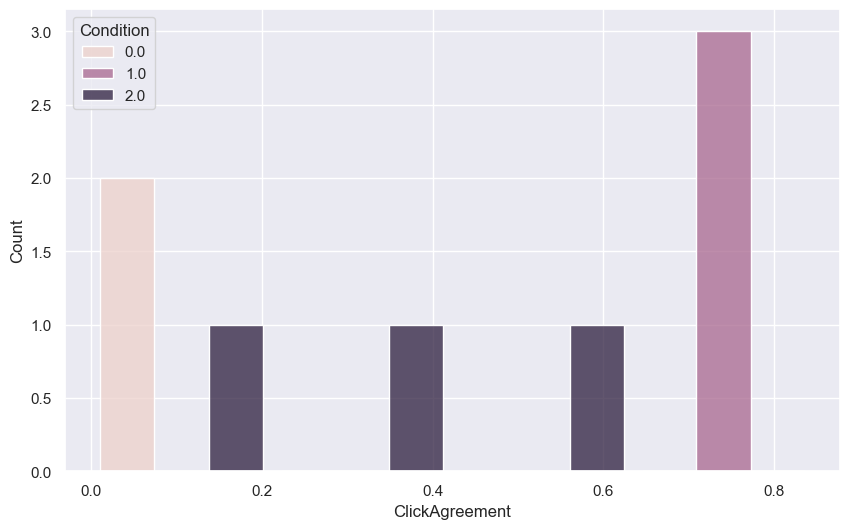

In [21]:
sns.histplot(df.groupby("Participant").mean(), x="ClickAgreement", hue="Condition", shrink=0.9, multiple="dodge")

In [22]:
participant_scores = df.groupby("Participant").agg(["mean", "std"])

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_7220\1370106099.py:1: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  participant_scores = df.groupby("Participant").agg(["mean", "std"])


In [23]:
participant_scores

Condition          Score           ExpectedScore            \
                 mean  std      mean       std          mean       std   
Participant                                                              
2                 1.0  0.0  3.733008  0.416318      3.632706  0.152487   
4                 2.0  0.0  3.477030  0.819772      3.460968  0.089073   
5                 0.0  0.0  3.589183  0.665538      3.481831  0.089742   
6                 1.0  0.0  4.021638  0.497270      3.668195  0.163259   
7                 2.0  0.0  3.669696  0.500087      3.500740  0.158346   
8                 0.0  0.0  3.539717  0.589417      3.540522  0.223240   
9                 1.0  0.0  4.001136  0.523369      3.664950  0.141619   
10                2.0  0.0  3.536523  0.558133      3.401164  0.000000   

            NumClicks           Selection            Seed           \
                 mean       std      mean       std  mean      std   
Participant                                                          
2                 4.8  0.632456       2.0  1.632993  16.5  3.02765   
4                 5.0  0.000000       1.2  1.619328  16.5  3.02765   
5                 4.9  0.316228       2.7  1.494434  16.5  3.02765   
6                 4.0  1.247219       2.5  1.354006  16.5  3.02765   
7                 4.9  0.316228       2.4  1.646545  16.5  3.02765   
8                 4.1  1.286684       2.6  1.349897  16.5  3.02765   
9                 4.9  0.316228       1.9  1.100505  16.5  3.02765   
10                0.0  0.000000       1.6  1.349897  16.5  3.02765   

            ClickAgreement            
                      mean       std  
Participant                           
2                 0.666667  0.293972  
4                 0.233333  0.116534  
5                 0.166667  0.078567  
6                 0.808333  0.270716  
7                 0.423333  0.114450  
8                 0.200000  0.131468  
9                 0.846667  0.123927  
10                0.000000  0.000000

In [24]:
participant_scores = participant_scores.sort_values(("Score", "mean"), ascending=False)
participant_scores

Condition          Score           ExpectedScore            \
                 mean  std      mean       std          mean       std   
Participant                                                              
6                 1.0  0.0  4.021638  0.497270      3.668195  0.163259   
9                 1.0  0.0  4.001136  0.523369      3.664950  0.141619   
2                 1.0  0.0  3.733008  0.416318      3.632706  0.152487   
7                 2.0  0.0  3.669696  0.500087      3.500740  0.158346   
5                 0.0  0.0  3.589183  0.665538      3.481831  0.089742   
8                 0.0  0.0  3.539717  0.589417      3.540522  0.223240   
10                2.0  0.0  3.536523  0.558133      3.401164  0.000000   
4                 2.0  0.0  3.477030  0.819772      3.460968  0.089073   

            NumClicks           Selection            Seed           \
                 mean       std      mean       std  mean      std   
Participant                                                          
6                 4.0  1.247219       2.5  1.354006  16.5  3.02765   
9                 4.9  0.316228       1.9  1.100505  16.5  3.02765   
2                 4.8  0.632456       2.0  1.632993  16.5  3.02765   
7                 4.9  0.316228       2.4  1.646545  16.5  3.02765   
5                 4.9  0.316228       2.7  1.494434  16.5  3.02765   
8                 4.1  1.286684       2.6  1.349897  16.5  3.02765   
10                0.0  0.000000       1.6  1.349897  16.5  3.02765   
4                 5.0  0.000000       1.2  1.619328  16.5  3.02765   

            ClickAgreement            
                      mean       std  
Participant                           
6                 0.808333  0.270716  
9                 0.846667  0.123927  
2                 0.666667  0.293972  
7                 0.423333  0.114450  
5                 0.166667  0.078567  
8                 0.200000  0.131468  
10                0.000000  0.000000  
4                 0.233333  0.116534

In [25]:
sorted_participants = participant_scores.index.tolist()
half_participants = math.ceil(len(sorted_participants)/2)
high_bonus = sorted_participants[:half_participants]
low_bonus = sorted_participants[half_participants:]
for id in high_bonus:
    print(f"{id},0.75")
for id in low_bonus:
    print(f"{id},0.25")

6,0.75
9,0.75
2,0.75
7,0.75
5,0.25
8,0.25
10,0.25
4,0.25


In [26]:
df.to_csv("./data/experiment_results/exp_4.csv")

In [2]:
df = pd.read_csv("./data/experiment_results/exp_4.csv")

In [3]:
df.groupby("Condition").mean()["Seed"]

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_22780\1187068146.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Condition").mean()["Seed"]


Condition
0    16.5
1    16.5
2    16.5
Name: Seed, dtype: float64